## Challenge Set 9
### McNulty - Poisson GLM Challenges

#### Updated:  11/5/15
#### By:  Bo, Reshama

##Table of Contents 

[Challenge01](#1) 

Model the damage incident counts (ship data) with a Poisson Regression.

[Challenge02](#2)

Try your model with months of service as the offset. Does it perform better?

[Challenge03](#3)

Now separate your data and check if you predict well (you can look at mean absolute error or mean squared error using sklearn.metrics).

[Challenge04](#4)

Deviance Compute the difference in Deviance statistics for your model and the null model. 

[Challenge05](#5)

Now, instead of a poisson regression, do an ordinary least squares regression with log Y. Compare the models. Are the coefficients close? Do they perform similarly?

[Challenge06](#6)

Now, let's do this on another dataset: Smoking and Cancer.  That population looks a lot like an offset!
Fit poisson and OLS models and compare them.

[Challenge06b](#6b)
GLM with Poisson

[Challenge06c](#6c)
OLS

[Bonus](#7)

Try all these things in R! Your numerical answers should all be the same.

-----------

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas.io.stata import StataReader
from scipy.stats import chisqprob

The dataset we will use is poached from STATA.

Here is the actual file: http://data.princeton.edu/wws509/datasets/ships.dta

More info: http://data.princeton.edu/wws509/datasets/#ships

Here are some details on this dataset:

The file has 34 rows corresponding to the observed combinations of type of ship, year of construction and period of operation.

Each row has information on five variables as follows:

 * ship type, coded 1-5 for A, B, C, D and E,
 * year of construction (1=1960-64, 2=1965-70, 3=1970-74, 4=1975-79),
 * period of operation (1=1960-74, 2=1975-79)
 * months of service, ranging from 63 to 20,370, and
 * damage incidents, ranging from 0 to 53.
 * Note that there no ships of type E built in 1960-64, and that ships built in 1970-74 could not have operated in 1960-74. These combinations are omitted from the data file.



### <a id='1'></a> Challenge 1

Model the damage incident counts with a Poisson Regression.

> Hint: You can look at the previous ipython notebook with the logistic GLM example to see how you can do GLM with statsmodels.
Remember that you will have to create dummy variables for categorical variables, and if you have time bins (like "1960-1964"), you have the option of either a) treating each bin as a category (and create dummies for each bin), or b) treat it as a continuous variable and take the mid-value (1962). Also remember to add a constant (to model the intercept).

Take a look at the statsmodels summary table, the goodness of fit indicators (Deviance, Pearson's chi square statistic) and the coefficients. Is this a good model?

In [2]:
#!wget http://data.princeton.edu/wws509/datasets/ships.dta

In [3]:
# this code updated on 10/6/15
data = pd.read_stata('ships.dta')

In [4]:
print data.shape
print data.head()

(34, 5)
  type construction operation  months  damage
0    A      1960-64   1960-74     127       0
1    A      1960-64   1975-79      63       0
2    A      1965-70   1960-74    1095       3
3    A      1965-70   1975-79    1095       4
4    A      1970-74   1960-74    1512       6


In [5]:
# this code no longer works since anaconda was updated
# # load dataset 
# reader = StataReader('ships.dta')
# data = reader.data() #a pandas DataFrame

In [6]:
print data[:5]

  type construction operation  months  damage
0    A      1960-64   1960-74     127       0
1    A      1960-64   1975-79      63       0
2    A      1965-70   1960-74    1095       3
3    A      1965-70   1975-79    1095       4
4    A      1970-74   1960-74    1512       6


In [7]:
# dummify rank
types = pd.get_dummies(data['type'], prefix='type')
construction = pd.get_dummies(data['construction'], prefix='construction')
operation    = pd.get_dummies(data['operation'], prefix='operation')

print types[:3]
print construction[:3]
print operation[:3]

dummies_only = pd.concat([types, construction,operation],axis=1)
print '-'*75
print dummies_only[:5]


   type_A  type_B  type_C  type_D  type_E
0       1       0       0       0       0
1       1       0       0       0       0
2       1       0       0       0       0
   construction_1960-64  construction_1965-70  construction_1970-74  \
0                     1                     0                     0   
1                     1                     0                     0   
2                     0                     1                     0   

   construction_1975-79  
0                     0  
1                     0  
2                     0  
   operation_1960-74  operation_1975-79
0                  1                  0
1                  0                  1
2                  1                  0
---------------------------------------------------------------------------
   type_A  type_B  type_C  type_D  type_E  construction_1960-64  \
0       1       0       0       0       0                     1   
1       1       0       0       0       0                     1   
2     

In [8]:
# Getting the design matrix (sm_X) ready to input into the GLM. 
# Remove the redundant dummy columns; add a column for the constant
subset_dummy = dummies_only[["type_B","type_C","type_D", "type_E",
                             "construction_1965-70", "construction_1970-74", 
                             "construction_1975-79", "operation_1975-79"
                             ]]

sm_X = pd.concat([data.months, subset_dummy], axis=1)
sm_X = sm.add_constant(sm_X)

print sm_X.shape
sm_X.head()

(34, 10)


,const,months,type_B,type_C,type_D,type_E,construction_1965-70,construction_1970-74,construction_1975-79,operation_1975-79
0,1,127,0,0,0,0,0,0,0,0
1,1,63,0,0,0,0,0,0,0,1
2,1,1095,0,0,0,0,1,0,0,0
3,1,1095,0,0,0,0,1,0,0,1
4,1,1512,0,0,0,0,0,1,0,0


In [9]:
# Our response variable, call it Y
Y = data.damage
print Y.shape
print Y.head()

(34,)
0    0
1    0
2    3
3    4
4    6
Name: damage, dtype: float32


In [10]:
## NOTE: without the offset, this model is incorrect. The correct model is in Challenge 2.

glm_no_offset = sm.GLM(Y, sm_X, family=sm.families.Poisson(link=sm.families.links.log)).fit()
glm_no_offset.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 damage   No. Observations:                   34
Model:                            GLM   Df Residuals:                       24
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -84.182
Date:                Thu, 05 Nov 2015   Deviance:                       70.498
Time:                        21:08:30   Pearson chi2:                     65.8
No. Iterations:                     9                                         
========================================================================================
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                    0.1786      0.277      0.645      0.519        -0.364     0.722
months                6.697e-05   8.52e-06      7.857      0.000      5.03e-05  8.37e-05
type_B                   0.6701      0.217      3.085      0.002         0.244     1.096
type_C                  -1.1916      0.328     -3.638      0.000        -1.833    -0.550
type_D                  -0.8294      0.288     -2.883      0.004        -1.393    -0.266
type_E                  -0.1493      0.235     -0.636      0.525        -0.610     0.311
construction_1965-70     1.0873      0.179      6.067      0.000         0.736     1.439
construction_1970-74     1.4998      0.225      6.673      0.000         1.059     1.940
construction_1975-79     0.8545      0.276      3.097      0.002         0.314     1.395
operation_1975-79        0.7284      0.136      5.369      0.000         0.462     0.994
========================================================================================
"""

In [11]:
## Both the model's Deviance and Chi-square test statistics 
## are Chi-squared distributed with n-p degrees of freedom, 
## where n = number of observations = 34, 
## and p = number of covariates (number of columns of X) = 9
print "Model:  no offset"
print "deviance:", glm_no_offset.deviance
print "pearson's chi-squared test statistic:", glm_no_offset.pearson_chi2

Model:  no offset
deviance: 70.4976721566
pearson's chi-squared test statistic: 65.7751214105


NOTE: rather than just adding number of months to the model as a covariate, it makes much more sense to add number of months as an offset (i.e. what we do in Challenge 2).



In [12]:
X_no_months = sm_X.drop(["months"], axis=1)
X_no_months.head(3)

,const,type_B,type_C,type_D,type_E,construction_1965-70,construction_1970-74,construction_1975-79,operation_1975-79
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1
2,1,0,0,0,0,1,0,0,0


### <a id='2'></a> Challenge 2

The months of service provides the time interval in which a ship has chances to acquire damages. It can be thought of "exposure", and this column can be used as an offset.  
 
Try your model with months of service as the offset. Does it perform better?

In [13]:
## This is the correct model.
## You need to add the offset.

logmonths = np.log(sm_X.months)

glm_offset = sm.GLM(Y, X_no_months, offset=logmonths, family=sm.families.Poisson()).fit()
glm_offset.summary()

## Note: the offset parameter doesn't get its own covariate output. 
## The would-be coefficient for the offset is 
## forced to be 1 (or as close to 1 as possible).

print "Model:  offset = logmonths"
print "deviance:", glm_offset.deviance
print "pearson's chi-squared test statistic:", glm_offset.pearson_chi2

Model:  offset = logmonths
deviance: 38.69504856
pearson's chi-squared test statistic: 42.2752462015


In [14]:
glm_offset.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 damage   No. Observations:                   34
Model:                            GLM   Df Residuals:                       25
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -68.281
Date:                Thu, 05 Nov 2015   Deviance:                       38.695
Time:                        21:08:30   Pearson chi2:                     42.3
No. Iterations:                     9                                         
========================================================================================
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                   -6.4059      0.217    -29.460      0.000        -6.832    -5.980
type_B                  -0.5433      0.178     -3.060      0.002        -0.891    -0.195
type_C                  -0.6874      0.329     -2.089      0.037        -1.332    -0.042
type_D                  -0.0760      0.291     -0.261      0.794        -0.645     0.494
type_E                   0.3256      0.236      1.380      0.168        -0.137     0.788
construction_1965-70     0.6971      0.150      4.659      0.000         0.404     0.990
construction_1970-74     0.8184      0.170      4.821      0.000         0.486     1.151
construction_1975-79     0.4534      0.233      1.945      0.052        -0.004     0.910
operation_1975-79        0.3845      0.118      3.251      0.001         0.153     0.616
========================================================================================
"""

In [15]:
# Just testing the assumption that the offset parameter should have coefficient of 1.
# We get the coefficient is 0.903, which is pretty close. 
# So our above assumption is OK.

test_X_log = pd.concat([logmonths, X_no_months], axis=1)
test_X_log = test_X_log.rename(columns={'months': 'logmonths'})
#print test_X_log.head()

glm_manual_log = sm.GLM(Y, test_X_log, family=sm.families.Poisson()).fit()
glm_manual_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 damage   No. Observations:                   34
Model:                            GLM   Df Residuals:                       24
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -67.835
Date:                Thu, 05 Nov 2015   Deviance:                       37.804
Time:                        21:08:30   Pearson chi2:                     39.4
No. Iterations:                     9                                         
========================================================================================
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
logmonths                0.9027      0.102      8.867      0.000         0.703     1.102
const                   -5.5940      0.872     -6.412      0.000        -7.304    -3.884
type_B                  -0.3499      0.270     -1.295      0.195        -0.879     0.180
type_C                  -0.7631      0.338     -2.257      0.024        -1.426    -0.100
type_D                  -0.1355      0.297     -0.456      0.648        -0.718     0.447
type_E                   0.2739      0.242      1.133      0.257        -0.200     0.748
construction_1965-70     0.6625      0.154      4.312      0.000         0.361     0.964
construction_1970-74     0.7597      0.178      4.276      0.000         0.412     1.108
construction_1975-79     0.3697      0.246      1.504      0.133        -0.112     0.852
operation_1975-79        0.3703      0.118      3.134      0.002         0.139     0.602
========================================================================================
"""

### <a id='3'></a> Challenge 3

Now separate your data and check if you predict well (you can look at mean absolute error or mean squared error using sklearn.metrics).

In [16]:
# test and train...

In [17]:
from math import log
sm_X['logmonths'] = sm_X['months'].apply(lambda x: log(x))
print sm_X[:5]

   const  months  type_B  type_C  type_D  type_E  construction_1965-70  \
0      1     127       0       0       0       0                     0   
1      1      63       0       0       0       0                     0   
2      1    1095       0       0       0       0                     1   
3      1    1095       0       0       0       0                     1   
4      1    1512       0       0       0       0                     0   

   construction_1970-74  construction_1975-79  operation_1975-79  logmonths  
0                     0                     0                  0   4.844187  
1                     0                     0                  1   4.143135  
2                     0                     0                  0   6.998510  
3                     0                     0                  1   6.998510  
4                     1                     0                  0   7.321189  


In [18]:
print sm_X.columns
X_forglm = sm_X.drop("months", axis=1)
print X_forglm.columns

Index([u'const', u'months', u'type_B', u'type_C', u'type_D', u'type_E',
       u'construction_1965-70', u'construction_1970-74',
       u'construction_1975-79', u'operation_1975-79', u'logmonths'],
      dtype='object')
Index([u'const', u'type_B', u'type_C', u'type_D', u'type_E',
       u'construction_1965-70', u'construction_1970-74',
       u'construction_1975-79', u'operation_1975-79', u'logmonths'],
      dtype='object')


In [19]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_forglm, Y, test_size=.30, random_state=4444)

print X_train.shape
print X_test.shape


(23, 10)
(11, 10)


In [20]:
glm_train = sm.GLM(Y_train, X_train, family=sm.families.Poisson()).fit()
glm_train.summary()

y_pred = glm_train.predict(X_test)

print "Model:  Training Set"
print "deviance:", glm_train.deviance
print "pearson's chi-squared test statistic:", glm_train.pearson_chi2

y_obs = Y_test
print "y_pred", y_pred
print y_obs

from sklearn.metrics import mean_squared_error

mean_squared_error(y_obs, y_pred)

Model:  Training Set
deviance: 25.6186721348
pearson's chi-squared test statistic: 29.487016212
y_pred [ 30.33896189   4.16404498   3.28370759   0.72115728   1.10531272
   0.25506496   0.58670575   9.82378737  10.91907357  67.25446562
   1.23882325]
32    12
3      4
30     7
23     0
14     1
20     1
15     1
13    18
31     5
7     39
25     2
Name: damage, dtype: float32


113.83566043040624

###Compare 3 Models

Model:  no offset
deviance: 49.9752187193
pearson's chi-squared test statistic: 39.618907712

Model:  offset = logmonths
deviance: 44.0586445985
pearson's chi-squared test statistic: 42.2752462015

Model:  Training Set
deviance: 44.3452260955
pearson's chi-squared test statistic: 29.487016212

MSE for Train/Test:  113.84


### <a id='4'></a> Challenge 4

Deviance. Compute the difference in Deviance statistics for your model and the null model. This is called the null deviance. You can do this in one of 2 ways:

 1. We need the deviance for the null model (a model where none of the explanatory variables are used; it's just a model with a mean guess). To do that, fit a poisson regression with only a constant. Get the deviance for this null model. Take the difference of deviances between your model and this null model.
 
 2. Use 
     > statsmodels.genmod.generalized_linear_model.GLMResults
 
Check if this difference is extreme enough that we can reject the null hypothesis. If we can't reject the null hypothesis, we cannot say that this model tells us more than that trivial, null model. To calculate the p-value (prob. of getting a deviance difference at least as extreme as this under the null hypothesis), we need to do a hypothesis test.

You can import the chi square test from scipy for this:

    from scipy.stats import chisqprob
    
Is your model better than the null model?

**Deviance**

$D = 2*[Log\_likelihood (saturated\ model) - Log\_likelihood (null\ model)]$

$D \sim \ {\chi}^2_{(n-p)} $

$D_{red} - D_{full} \sim  {\chi}^2_{(full - red)}$

In [21]:
# First way to compare deviance
LL_saturated = -68.281
LL_null = -122.10

df_saturated = 8
df_null = 0

deviance = 2*(LL_saturated - LL_null)
deg_freedom = df_saturated - df_null
print "Deviance: ", deviance
print "degrees of freedom: ", deg_freedom

from scipy.stats import chisqprob

p_value = chisqprob(deviance, deg_freedom)

print
print "p-value: ", p_value
print("%.6f" % p_value)
print
print "p-value is < 0.05"
print "if p < 0.05, then fuller model is better."
print
print "Conclusion:  GLM offset model is better."


Deviance:  107.638
degrees of freedom:  8

p-value:  1.16355243681e-19
0.000000

p-value is < 0.05
if p < 0.05, then fuller model is better.

Conclusion:  GLM offset model is better.


In [22]:
## Method 1:
## Getting deviance for null model
glm_null_model = sm.GLM(Y, sm_X.const, offset=logmonths, family=sm.families.Poisson()).fit()
print glm_null_model.summary()

# Note: glm_null_model.null_deviance = glm_null_model.deviance


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 damage   No. Observations:                   34
Model:                            GLM   Df Residuals:                       33
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -122.10
Date:                Thu, 05 Nov 2015   Deviance:                       146.33
Time:                        21:08:31   Pearson chi2:                     190.
No. Iterations:                     9                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -6.1301      0.053   -115.662      0.000        -6.234    -6.026


In [23]:
# Second way to compare deviance
print "reduced model (null)       deviance ", glm_null_model.deviance
print "full model    (glm_offset) deviance ", glm_offset.deviance

print

d_diff = glm_null_model.deviance - glm_offset.deviance
print "Difference in Deviances is %.2f" % d_diff
print
print "Chi-squared df"
print "full    (glm_offset) df: ", 8
print "reduced (glm_null)   df: ", 0

print
print "Find p-value for " + str(d_diff) + " with 8 df"

from scipy.stats import chisqprob
p_value = chisqprob(d_diff, 8)

print "p-value: ", p_value
print("%.6f" % p_value)
print "p-value is < 0.05"
print "GLM offset model is better."
 

reduced model (null)       deviance  146.328315595
full model    (glm_offset) deviance  38.69504856

Difference in Deviances is 107.63

Chi-squared df
full    (glm_offset) df:  8
reduced (glm_null)   df:  0

Find p-value for 107.633267035 with 8 df
p-value:  1.16615828764e-19
0.000000
p-value is < 0.05
GLM offset model is better.


Conclusion:  Since the p-value is small, there is evidence that the addition of
X vars explains a significant amount (more) of the
deviance

**Extra Resource:**  lots of good discussions on Deviance on Stack Exchange

http://stats.stackexchange.com/questions/6581/what-is-deviance-specifically-in-cart-rpart

### <a id='5'></a> Challenge 5

Now, instead of a poisson regression, do an ordinary least squares regression with log Y. Compare the models. Are the coefficients close? Do they perform similarly?

In [24]:
Y_hack = Y.replace(0, 0.01)
logY = np.log(Y_hack)

linear_model = sm.OLS(logY, test_X_log).fit()
linear_model.summary()

## The F-statistic p-value suggests that the model itself 
## explains the variation in the data better than a null model,
## but it misleadingly suggests that none of the covariates 
## other than logmonths and the constant are significant. 
## This suggests that there might be collinearity in the model.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 damage   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     14.07
Date:                Thu, 05 Nov 2015   Prob (F-statistic):           1.43e-07
Time:                        21:08:31   Log-Likelihood:                -54.030
No. Observations:                  34   AIC:                             128.1
Df Residuals:                      24   BIC:                             143.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
logmonths                1.5826      0.283      5.601      0.000         0.999     2.166
const                  -11.5168      1.778     -6.477      0.000       -15.187    -7.847
type_B                  -1.5012      1.157     -1.298      0.207        -3.888     0.886
type_C                  -0.4156      0.754     -0.551      0.587        -1.972     1.141
type_D                  -1.0339      0.775     -1.333      0.195        -2.634     0.567
type_E                   0.9529      0.799      1.192      0.245        -0.697     2.603
construction_1965-70     0.3999      0.698      0.573      0.572        -1.040     1.840
construction_1970-74     1.6630      0.755      2.203      0.037         0.105     3.221
construction_1975-79     1.1490      0.886      1.296      0.207        -0.680     2.978
operation_1975-79        0.6693      0.527      1.270      0.216        -0.418     1.757
==============================================================================
Omnibus:                        3.949   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                2.521
Skew:                          -0.525   Prob(JB):                        0.284
Kurtosis:                       3.823   Cond. No.                         61.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### <a id='6'></a> Challenge 6

Now, let's do this on another dataset: Smoking and Cancer.

You can get it here: [http://data.princeton.edu/wws509/datasets/smoking.dta](http://data.princeton.edu/wws509/datasets/smoking.dta)
This dataset has information on lung cancer deaths by age and smoking status.
It has these columns:

- age: in five-year age groups coded 1 to 9 for 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80+.
- smoking status: coded 1 = doesn't smoke, 2 = smokes cigars or pipe only, 3 = smokes cigarrettes and cigar or pipe, and 4 = smokes cigarrettes only,
- population: in hundreds of thousands, and
- deaths: number of lung cancer deaths in a year.

That population looks a lot like an offset!

Fit poisson and OLS models and compare them.

In [25]:
#!wget http://data.princeton.edu/wws509/datasets/smoking.dta

In [26]:
# load dataset 
reader = StataReader('smoking.dta')
smoking_data = reader.data() #a pandas DataFrame
print smoking_data.shape
smoking_data.head()

(36, 4)


/Users/reshamashaikh/anaconda/lib/python2.7/site-packages/pandas/io/stata.py:1254: UserWarning: 'data' is deprecated, use 'read' instead
  warnings.warn("'data' is deprecated, use 'read' instead")


,age,smoke,pop,dead
0,40-44,Doesn't smoke,656,18
1,45-49,Doesn't smoke,359,22
2,50-54,Doesn't smoke,249,19
3,55-59,Doesn't smoke,632,55
4,60-64,Doesn't smoke,1067,117


In [27]:
# set population in hundred thousands
smoking_data['pop_ht'] = smoking_data['pop'].apply(lambda x: (x*1000))

In [28]:
smoking_data.describe()

,pop,dead,pop_ht
count,36.000000,36.000000,36.000000
mean,1558.944458,253.611115,1558944.444444
std,1562.232137,262.597497,1562232.174888
min,98.000000,2.000000,98000.000000
25%,369.250000,100.500000,369250.000000
50%,858.500000,171.500000,858500.000000
75%,2305.500000,274.000000,2305500.000000
max,6052.000000,1001.000000,6052000.000000


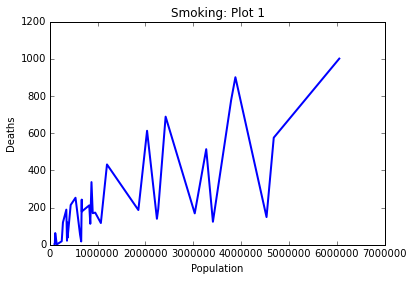

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
smoking_data.sort('pop_ht', inplace=True)
plt.plot(smoking_data['pop_ht'], smoking_data['dead'], linewidth=2.0)
plt.title("Smoking: Plot 1")
plt.xlabel("Population")
plt.ylabel("Deaths")
plt.show()

In [30]:
check_smoking = smoking_data.copy(deep=True)

print check_smoking[:5]

check_smoking['poplog']  = np.log(check_smoking['pop_ht'])
check_smoking['deadlog'] = np.log(check_smoking['dead'])

check_smoking.describe()

      age                       smoke  pop  dead  pop_ht
11  50-54  Smokes cigars or pipe only   98     3   98000
10  45-49  Smokes cigars or pipe only  104     4  104000
35    80+      smokes cigarettes only  113    63  113000
9   40-44  Smokes cigars or pipe only  145     2  145000
2   50-54               Doesn't smoke  249    19  249000


,pop,dead,pop_ht,poplog,deadlog
count,36.000000,36.000000,36.000000,36.000000,36.000000
mean,1558.944458,253.611115,1558944.444444,13.700535,4.822854
std,1562.232217,262.597512,1562232.174888,1.157593,1.531767
min,98.000000,2.000000,98000.000000,11.492723,0.693147
25%,369.250000,100.500000,369250.000000,12.819145,4.581325
50%,858.500000,171.500000,858500.000000,13.662836,5.144545
75%,2305.500000,274.000000,2305500.000000,14.650399,5.605063
max,6052.000000,1001.000000,6052000.000000,15.615899,6.908755


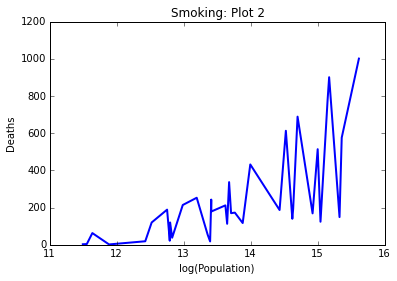

In [31]:
# re-graph using log values for population only
check_smoking.sort('poplog', inplace=True)
plt.plot(check_smoking['poplog'], check_smoking['dead'], linewidth=2.0)

plt.title("Smoking: Plot 2")
plt.xlabel("log(Population)")
plt.ylabel("Deaths")

plt.show()

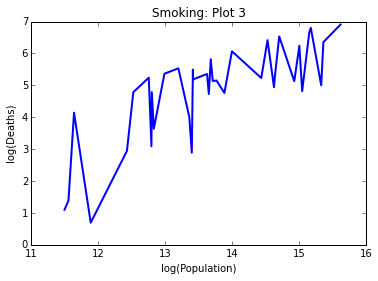

In [32]:
# re-graph using log values for both dead and population
check_smoking.sort('poplog', inplace=True)
plt.plot(check_smoking['poplog'], check_smoking['deadlog'], linewidth=2.0)

plt.title("Smoking: Plot 3")
plt.xlabel("log(Population)")
plt.ylabel("log(Deaths)")

plt.show()

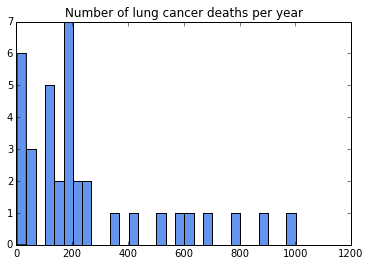

In [33]:
plt.hist(check_smoking['dead'], bins=30, color="#6495ED") 
plt.title("Number of lung cancer deaths per year")
plt.show()

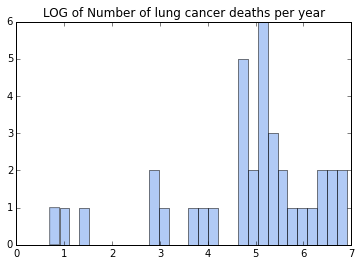

In [34]:
plt.hist(check_smoking['deadlog'], bins=30, color="#6496ED", alpha=0.5)
plt.title("LOG of Number of lung cancer deaths per year")
plt.show()

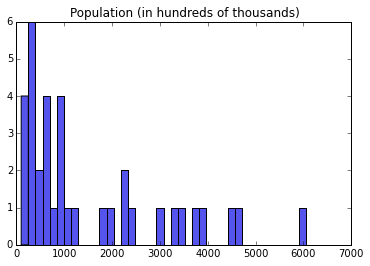

In [35]:
plt.hist(check_smoking['pop'], bins=40, color="#5555ED") 
plt.title("Population (in hundreds of thousands)")
plt.show()

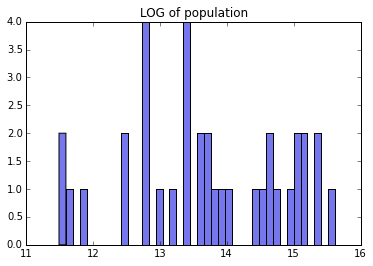

In [36]:
plt.hist(check_smoking['poplog'], bins=40, color="#7777ED") 
plt.title("LOG of population")
plt.show()

In [37]:
print smoking_data.dtypes

age       category
smoke     category
pop        float32
dead       float32
pop_ht     float64
dtype: object


In [38]:
smoking_data = check_smoking

In [39]:
print smoking_data.dtypes

age        category
smoke      category
pop         float32
dead        float32
pop_ht      float64
poplog      float64
deadlog     float32
dtype: object


In [40]:
smoking_data['deathrate'] = (smoking_data['deadlog']) / (smoking_data['poplog'])

In [41]:
by_smokegrp = smoking_data.groupby('smoke')
print by_smokegrp.count()

by_agegrp = smoking_data.groupby('age')
print by_agegrp.count()


                                     age  pop  dead  pop_ht  poplog  deadlog  \
smoke                                                                          
Doesn't smoke                          9    9     9       9       9        9   
Smokes cigars or pipe only             9    9     9       9       9        9   
Smokes cigarettes and cigar or pipe    9    9     9       9       9        9   
smokes cigarettes only                 9    9     9       9       9        9   

                                     deathrate  
smoke                                           
Doesn't smoke                                9  
Smokes cigars or pipe only                   9  
Smokes cigarettes and cigar or pipe          9  
smokes cigarettes only                       9  
       smoke  pop  dead  pop_ht  poplog  deadlog  deathrate
age                                                        
40-44      4    4     4       4       4        4          4
45-49      4    4     4       4       4      

In [42]:
print by_agegrp.mean() 
print '\n'
print by_smokegrp.mean() 

           pop    dead   pop_ht     poplog   deadlog  deathrate
age                                                            
40-44  2185.50   73.25  2185500  13.911770  3.351937   0.230265
45-49  1433.00   83.75  1433000  13.472209  3.637219   0.260841
50-54  1116.25  100.50  1116250  13.245784  3.634212   0.263668
55-59  2239.00  295.75  2239000  14.135708  5.060812   0.353398
60-64  2939.00  502.25  2939000  14.573169  5.763761   0.392830
65-69  2036.75  483.25  2036750  14.335253  5.906959   0.410536
70-74  1180.00  359.00  1180000  13.888162  5.757691   0.413886
75-79   583.75  228.50   583750  13.217493  5.366653   0.405621
80+     317.25  156.25   317250  12.525270  4.926441   0.392230


                                             pop        dead          pop_ht  \
smoke                                                                          
Doesn't smoke                         573.666687   91.111115   573666.666667   
Smokes cigars or pipe only            504.666656  115.

In [43]:
print smoking_data[:5]

      age                       smoke  pop  dead  pop_ht     poplog   deadlog  \
11  50-54  Smokes cigars or pipe only   98     3   98000  11.492723  1.098612   
10  45-49  Smokes cigars or pipe only  104     4  104000  11.552146  1.386294   
35    80+      smokes cigarettes only  113    63  113000  11.635143  4.143135   
9   40-44  Smokes cigars or pipe only  145     2  145000  11.884489  0.693147   
2   50-54               Doesn't smoke  249    19  249000  12.425208  2.944439   

    deathrate  
11   0.095592  
10   0.120003  
35   0.356088  
9    0.058324  
2    0.236973  


In [44]:
# Set dummy variables
age   = pd.get_dummies(smoking_data['age'], prefix='age')
smoke = pd.get_dummies(smoking_data['smoke'], prefix='smoke')

print age[:3]
print smoke[:3]

dummies_only = pd.concat([age, smoke],axis=1)

# add constant
dummies_only = sm.add_constant(dummies_only)
print '-'*75
print dummies_only[:5]


    age_40-44  age_45-49  age_50-54  age_55-59  age_60-64  age_65-69  \
11          0          0          1          0          0          0   
10          0          1          0          0          0          0   
35          0          0          0          0          0          0   

    age_70-74  age_75-79  age_80+  
11          0          0        0  
10          0          0        0  
35          0          0        1  
    smoke_Doesn't smoke  smoke_Smokes cigars or pipe only  \
11                    0                                 1   
10                    0                                 1   
35                    0                                 0   

    smoke_Smokes cigarettes and cigar or pipe  smoke_smokes cigarettes only  
11                                          0                             0  
10                                          0                             0  
35                                          0                             1  
----------

#### Challenge 6 - Model 1 (Y=deathrate, no offset parameter used)

In [45]:
Y_smoking = smoking_data['deathrate']
X_smoking = dummies_only

print X_smoking.shape
print X_smoking.head(3)

print Y_smoking.shape
print Y_smoking.head(3)


(36, 14)
    const  age_40-44  age_45-49  age_50-54  age_55-59  age_60-64  age_65-69  \
11      1          0          0          1          0          0          0   
10      1          0          1          0          0          0          0   
35      1          0          0          0          0          0          0   

    age_70-74  age_75-79  age_80+  smoke_Doesn't smoke  \
11          0          0        0                    0   
10          0          0        0                    0   
35          0          0        1                    0   

    smoke_Smokes cigars or pipe only  \
11                                 1   
10                                 1   
35                                 0   

    smoke_Smokes cigarettes and cigar or pipe  smoke_smokes cigarettes only  
11                                          0                             0  
10                                          0                             0  
35                                          0 

In [46]:
## Model 1:  Y = deathrate ; no offset parameter used

glm_no_offset = sm.GLM(Y_smoking, X_smoking, \
                     family=sm.families.Poisson(link=sm.families.links.log)).fit()

print "Data:      smoking"
print "Model_Num: 1"
print "Model:     GLM(no offset), Y = deathrate" 
glm_no_offset.summary()


Data:      smoking
Model_Num: 1
Model:     GLM(no offset), Y = deathrate


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              deathrate   No. Observations:                   36
Model:                            GLM   Df Residuals:                       24
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -21.366
Date:                Thu, 05 Nov 2015   Deviance:                      0.41879
Time:                        21:08:33   Pearson chi2:                    0.372
No. Iterations:                     7                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------
const                                        -0.8027      0.215     -3.729      0.000        -1.225    -0.381
age_40-44                                    -0.4765      0.967     -0.493      0.622        -2.372     1.419
age_45-49                                    -0.3519      0.913     -0.385      0.700        -2.141     1.438
age_50-54                                    -0.3411      0.909     -0.375      0.707        -2.122     1.440
age_55-59                                    -0.0482      0.796     -0.060      0.952        -1.609     1.512
age_60-64                                     0.0576      0.760      0.076      0.940        -1.432     1.547
age_65-69                                     0.1017      0.745      0.136      0.891        -1.359     1.563
age_70-74                                     0.1098      0.743      0.148      0.882        -1.346     1.565
age_75-79                                     0.0897      0.749      0.120      0.905        -1.379     1.558
age_80+                                       0.0561      0.760      0.074      0.941        -1.434     1.546
smoke_Doesn't smoke                          -0.2789      0.512     -0.545      0.586        -1.282     0.724
smoke_Smokes cigars or pipe only             -0.4116      0.540     -0.763      0.446        -1.470     0.646
smoke_Smokes cigarettes and cigar or pipe    -0.0436      0.467     -0.093      0.926        -0.960     0.873
smoke_smokes cigarettes only                 -0.0685      0.472     -0.145      0.885        -0.993     0.856
=============================================================================================================
"""

In [47]:
# Note:  This is considered a bad model, has linear link (rather than Poisson)
print "Data:                smoking"
print "Model_Num:           1"
print "Model:               GLM(no offset), Y = deathrate (deadlog/poplog)" 
print "deviance:           ", glm_no_offset.deviance
print "pearson chi-squared:", glm_no_offset.pearson_chi2

Data:                smoking
Model_Num:           1
Model:               GLM(no offset), Y = deathrate (deadlog/poplog)
deviance:            0.418792389366
pearson chi-squared: 0.372144392497


### <a id='6b'></a> Challenge 6b - GLM with Poisson

#### Challenge 6 - Model 2 (Y=deadlog, offset=poplog)

Now try with offset, using population as offset

In [48]:
print smoking_data.columns
print "\n"
print X_smoking.columns
print "\n"
print Y_smoking[:5]
#Y_smoking = smoking_data['deathrate']

Index([      u'age',     u'smoke',       u'pop',      u'dead',    u'pop_ht',
          u'poplog',   u'deadlog', u'deathrate'],
      dtype='object')


Index([                                    u'const',
                                       u'age_40-44',
                                       u'age_45-49',
                                       u'age_50-54',
                                       u'age_55-59',
                                       u'age_60-64',
                                       u'age_65-69',
                                       u'age_70-74',
                                       u'age_75-79',
                                         u'age_80+',
                             u'smoke_Doesn't smoke',
                u'smoke_Smokes cigars or pipe only',
       u'smoke_Smokes cigarettes and cigar or pipe',
                    u'smoke_smokes cigarettes only'],
      dtype='object')


11    0.095592
10    0.120003
35    0.356088
9     0.058324
2     0.236973
Name: d

In [49]:
print "Data:                smoking"
print "Model_Num:           2"
print "Model:               GLM: Y = deadlog (offset = logpop)" 
print "\n"

## Add population as offset to this model

Y_smoking_dead = smoking_data['deadlog']
#smoking_pop_offset = smoking_data['pop']
logpop = np.log(smoking_data['poplog'])

print "X:          "
#print X_smoking[:5]
print X_smoking.columns
print "\nY:          " 
print Y_smoking_dead[:5]
print "\noffset:     "
print logpop[:5]



Data:                smoking
Model_Num:           2
Model:               GLM: Y = deadlog (offset = logpop)


X:          
Index([                                    u'const',
                                       u'age_40-44',
                                       u'age_45-49',
                                       u'age_50-54',
                                       u'age_55-59',
                                       u'age_60-64',
                                       u'age_65-69',
                                       u'age_70-74',
                                       u'age_75-79',
                                         u'age_80+',
                             u'smoke_Doesn't smoke',
                u'smoke_Smokes cigars or pipe only',
       u'smoke_Smokes cigarettes and cigar or pipe',
                    u'smoke_smokes cigarettes only'],
      dtype='object')

Y:          
11    1.098612
10    1.386294
35    4.143135
9     0.693147
2     2.944439
Name: deadlog, dtype: f

In [50]:
print "Data:                smoking"
print "Model_Num:           2"
print "Model:               GLM: Y = deadlog (offset = logpop)"

glm_offset = sm.GLM(Y_smoking_dead, X_smoking, \
                    offset=logpop, family=sm.families.Poisson()).fit()
glm_offset.summary()

## Note: the offset parameter doesn't get its own covariate output. 
## The would-be coefficient for the offset is 
## forced to be 1 (or as close to 1 as possible).

Data:                smoking
Model_Num:           2
Model:               GLM: Y = deadlog (offset = logpop)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                deadlog   No. Observations:                   36
Model:                            GLM   Df Residuals:                       24
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -63.240
Date:                Thu, 05 Nov 2015   Deviance:                       5.2232
Time:                        21:08:34   Pearson chi2:                     4.57
No. Iterations:                     7                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------
const                                        -0.7958      0.058    -13.691      0.000        -0.910    -0.682
age_40-44                                    -0.4535      0.254     -1.786      0.074        -0.951     0.044
age_45-49                                    -0.3402      0.245     -1.391      0.164        -0.820     0.139
age_50-54                                    -0.3239      0.245     -1.324      0.186        -0.803     0.156
age_55-59                                    -0.0542      0.211     -0.257      0.797        -0.467     0.359
age_60-64                                     0.0482      0.199      0.242      0.809        -0.342     0.438
age_65-69                                     0.0914      0.197      0.464      0.643        -0.295     0.477
age_70-74                                     0.0997      0.199      0.501      0.617        -0.291     0.490
age_75-79                                     0.0817      0.205      0.398      0.691        -0.321     0.484
age_80+                                       0.0549      0.213      0.257      0.797        -0.363     0.473
smoke_Doesn't smoke                          -0.2848      0.141     -2.027      0.043        -0.560    -0.009
smoke_Smokes cigars or pipe only             -0.3983      0.148     -2.689      0.007        -0.689    -0.108
smoke_Smokes cigarettes and cigar or pipe    -0.0460      0.123     -0.374      0.709        -0.287     0.195
smoke_smokes cigarettes only                 -0.0666      0.126     -0.530      0.596        -0.313     0.180
=============================================================================================================
"""

In [51]:
print "Data:                smoking"
print "Model_Num:           2"
print "Model:               GLM: Y = deadlog (offset = logpop)" 
print "deviance:           ", glm_offset.deviance
print "pearson chi-squared:", glm_offset.pearson_chi2

#print "\nparameters: "
#print glm_offset.params


Data:                smoking
Model_Num:           2
Model:               GLM: Y = deadlog (offset = logpop)
deviance:            5.22324006947
pearson chi-squared: 4.57119393402


#### <a id='6c'></a> Challenge 6c - OLS

#### Challenge 6 - Model 3 (OLS, Y=deadlog)

In [52]:
#Y_hack = Y.replace(0, 0.01)
#logY = np.log(Y_hack)

# Set dummy variables
age   = pd.get_dummies(smoking_data['age'], prefix='age')
smoke = pd.get_dummies(smoking_data['smoke'], prefix='smoke')
poplog= smoking_data['poplog']

X_smoking_pop = pd.concat([age, smoke, poplog], axis=1)
# add constant
X_smoking_pop = sm.add_constant(X_smoking_pop)

# tranform Y to log
Y_smoking_dead = smoking_data['deadlog']

print "X:          "
print X_smoking_pop[:5]
print "\nY:          " 
print Y_smoking_dead[:5]
#print "\noffset:     "
#print logpop[:5]

#print X_smoking_pop[:5]
#print Y_smoking_dead.describe()


X:          
    const  age_40-44  age_45-49  age_50-54  age_55-59  age_60-64  age_65-69  \
11      1          0          0          1          0          0          0   
10      1          0          1          0          0          0          0   
35      1          0          0          0          0          0          0   
9       1          1          0          0          0          0          0   
2       1          0          0          1          0          0          0   

    age_70-74  age_75-79  age_80+  smoke_Doesn't smoke  \
11          0          0        0                    0   
10          0          0        0                    0   
35          0          0        1                    0   
9           0          0        0                    0   
2           0          0        0                    1   

    smoke_Smokes cigars or pipe only  \
11                                 1   
10                                 1   
35                                 0   
9  

In [53]:
print "Data:                smoking"
print "Model_Num:           3"
print "Model:               OLS, Y = deadlog"

linear_model = sm.OLS(Y_smoking_dead, X_smoking_pop).fit()
linear_model.summary()

Data:                smoking
Model_Num:           3
Model:               OLS, Y = deadlog


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                deadlog   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     257.0
Date:                Thu, 05 Nov 2015   Prob (F-statistic):           1.59e-21
Time:                        21:08:34   Log-Likelihood:                 22.379
No. Observations:                  36   AIC:                            -18.76
Df Residuals:                      23   BIC:                             1.828
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------
const                                        -8.0129      0.445    -17.997      0.000        -8.934    -7.092
age_40-44                                    -2.6038      0.097    -26.954      0.000        -2.804    -2.404
age_45-49                                    -1.8138      0.086    -21.048      0.000        -1.992    -1.636
age_50-54                                    -1.5569      0.082    -18.965      0.000        -1.727    -1.387
age_55-59                                    -1.1520      0.103    -11.193      0.000        -1.365    -0.939
age_60-64                                    -0.9513      0.117     -8.151      0.000        -1.193    -0.710
age_65-69                                    -0.5349      0.109     -4.908      0.000        -0.760    -0.309
age_70-74                                    -0.1709      0.096     -1.781      0.088        -0.369     0.028
age_75-79                                     0.2080      0.082      2.548      0.018         0.039     0.377
age_80+                                       0.5626      0.077      7.333      0.000         0.404     0.721
smoke_Doesn't smoke                          -2.0085      0.099    -20.374      0.000        -2.212    -1.805
smoke_Smokes cigars or pipe only             -2.1414      0.086    -24.788      0.000        -2.320    -1.963
smoke_Smokes cigarettes and cigar or pipe    -2.0505      0.161    -12.744      0.000        -2.383    -1.718
smoke_smokes cigarettes only                 -1.8125      0.140    -12.922      0.000        -2.103    -1.522
poplog                                        1.1481      0.044     25.981      0.000         1.057     1.239
==============================================================================
Omnibus:                        3.745   Durbin-Watson:                   2.345
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                2.404
Skew:                          -0.477   Prob(JB):                        0.301
Kurtosis:                       3.832   Cond. No.                     2.75e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.06e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [54]:
print "Data:                smoking"
print "Model_Num:           3"
print "Model:               OLS, Y = deadlog" 

print "\nparameters: "
#print linear_model.params
print linear_model.summary()

Data:                smoking
Model_Num:           3
Model:               OLS, Y = deadlog

parameters: 
                            OLS Regression Results                            
Dep. Variable:                deadlog   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     257.0
Date:                Thu, 05 Nov 2015   Prob (F-statistic):           1.59e-21
Time:                        21:08:34   Log-Likelihood:                 22.379
No. Observations:                  36   AIC:                            -18.76
Df Residuals:                      23   BIC:                             1.828
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [95.0% Conf. In

Compare p-values between the two models.  In OLS, almost all p-values are significant (plus warning message).  In the GLM/Poisson, just a few of the variables are significant, which provides more information.

http://courses.education.illinois.edu/EdPsy589/lectures/4glm3-ha-online.pdf

### <a id='7'></a> Bonus

Try all these things in R! 
Your numerical answers should all be the same.